Participate in the design of an autonomous car
----------------

#### In this notebook, we will study the two pretrained models vgg_unet and mobilenet_segnet with respect to the augmentation Horizontal-flip and Guassian blur.

In [ ]:
#Import the libraries
import pandas as pd
import numpy as np
import os, glob
import random
from time import time
import tqdm
from collections import namedtuple

import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

from imgaug import augmenters as iaa

In [ ]:
pip uninstall imgaug

Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/imgaug-0.2.9.dist-info/*
    /usr/local/lib/python3.7/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.2.9


In [ ]:
pip install imgaug

     |████████████████████████████████| 948 kB 4.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint_path='/content/drive/MyDrive/P08/checkpoints'
model_path = '/content/drive/MyDrive/P08/models'
train_input_dir = '/content/drive/MyDrive/P08/train/images'
train_mask_dir = '/content/drive/MyDrive/P08/train/masks30'
train_target_dir = '/content/drive/MyDrive/P08/train/masks'
val_input_dir = '/content/drive/MyDrive/P08/val/images'
val_mask_dir = '/content/drive/MyDrive/P08/val/masks30'
val_target_dir = '/content/drive/MyDrive/P08/val/masks'
test_input_dir = '/content/drive/MyDrive/P08/test/images'
test_mask_dir = '/content/drive/MyDrive/P08/test/masks30'
test_target_dir = '/content/drive/MyDrive/P08/test/masks'

In [ ]:
train_input_path = sorted(glob.glob(train_input_dir + '/*.png'))
train_mask_path = sorted(glob.glob(train_mask_dir +'/*.png'))
train_target_path = sorted(glob.glob(train_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(train_input_path), 
      ' - Number of original masks: ', len(train_mask_path),
      ' - Number of masks in 8 categories: ', len(train_target_path))
print(train_input_path[0] + '\n')

val_input_path = sorted(glob.glob(val_input_dir + '/*.png'))
val_mask_path = sorted(glob.glob(val_mask_dir +'/*.png'))
val_target_path = sorted(glob.glob(val_target_dir +'/*.png'))
print('VAL -- Number of images: ', len(val_input_path), 
      ' - Number of original masks: ', len(val_mask_path),
      ' - Number of masks in 8 categories: ', len(val_target_path))
print(val_input_path[0] + '\n')

test_input_path = sorted(glob.glob(test_input_dir + '/*.png'))
test_mask_path = sorted(glob.glob(test_mask_dir +'/*.png'))
test_target_path = sorted(glob.glob(test_target_dir +'/*.png'))
print('TEST -- Number of images: ', len(test_input_path), 
      ' - Number of original masks: ', len(test_mask_path),
      ' - Number of masks in 8 categories: ', len(test_target_path))
print(test_input_path[0])

TRAIN -- Number of images:  2400  - Number of original masks:  2400  - Number of masks in 8 categories:  2400
/content/drive/MyDrive/P08/train/images/aachen_000000_000019.png

VAL -- Number of images:  575  - Number of original masks:  575  - Number of masks in 8 categories:  575
/content/drive/MyDrive/P08/val/images/stuttgart_000124_000019.png

TEST -- Number of images:  500  - Number of original masks:  500  - Number of masks in 8 categories:  500
/content/drive/MyDrive/P08/test/images/frankfurt_000000_000294.png


In [ ]:
df_result = pd.DataFrame(
    columns= ['model',
              'epoch',
              'training_time',
              'eval_time',
              'mean_IoU',
              'void_IoU',
              'flat_IoU',
              'construction_IoU',
              'object_IoU',
              'nature_IoU',
              'sky_IoU',
              'human_IoU',
              'vehicule_IoU'])

In [ ]:
# Function to resize image
def resize_dataset(pred, img_width, img_height):
    img = pred
    # Use interpolation inter_nearest to use integer with cv2
    resized_img = cv2.resize(img, dsize=(img_width, img_height),
                             interpolation=cv2.INTER_NEAREST)
    return resized_img

# Function to plot original images and masks VS. predicted masks
def plot_image_mask_prediction(test_input_path, test_target_path, 
                               img_height, img_width, random=True, n=2):
    
    if random:
        # Generate random images/masks of n-number
        ids = np.random.choice(np.arange(len(test_input_path)), size=n)
        print(ids)
    
    else:
        ids = [498, 175]
    
    # Plot
    for i in ids:
        image = img_to_array(load_img(f'{test_input_path[i]}'))/255.
        mask = img_to_array(load_img(f'{test_target_path[i]}',
                                     color_mode = "grayscale"))
        mask = np.squeeze(mask)
        pred = model.predict_segmentation(inp=test_input_path[i])
        pred= resize_dataset(pred, img_width, img_height)
        
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(1, 3, 1)
        ax.set_title('Image')
        ax.imshow(image)
        
        ax1 = fig.add_subplot(1, 3, 2)
        ax1.set_title('True mask')
        ax1.imshow(mask, cmap='nipy_spectral_r' )
        
        ax2 = fig.add_subplot(1, 3, 3)
        ax2.set_title('predicted_Mask')
        ax2.imshow(pred, cmap='nipy_spectral_r')

#### Dice Loss

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)

    numerator = 2 * tf.reduce_sum(y_true * y_pred) + smooth
    denominator = tf.reduce_sum(y_true + y_pred) + smooth

    return 1 - numerator / denominator

#### Balanced Cross Entropy

In [ ]:
beta=0.5

def balanced_cross_entropy(beta):
  def loss(y_true, y_pred):
    weight_a = beta * tf.cast(y_true, tf.float32)
    weight_b = (1 - beta) * tf.cast(1 - y_true, tf.float32)
    
    o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b
    return tf.reduce_mean(o)

  return loss

#### Hyperparameters for the model

In [ ]:
img_height, img_width = 256, 512
img_size = (img_height, img_width)
batch_size = 20
n_classes = 8
samples = len(train_input_path)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
score_IoU = tf.keras.metrics.MeanIoU(num_classes=8,
                                     name='mean_IoU')
epochs = 10

In [ ]:
from IPython.display import clear_output
!pip install --upgrade git+https://github.com/santra11/image-segmentation-keras.git
clear_output()

from keras_segmentation.models.unet import vgg_unet
from keras_segmentation.models.segnet import mobilenet_segnet

### Use custom augmentation horizontal flip and Guassian Blur

In [ ]:
def custom_augmentation():
    return  iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.GaussianBlur(sigma=(0, 3.0)), # Guaissian Blur
            iaa.Fliplr(0.5),  # horizontally flip 50% of all images
        ])

### Model Mobilenet Segnet

In [ ]:
# Name next model to benchmark
model_name= 'mobilenet_segnet'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

17235968/17225924 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 512, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 258, 514, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 128, 256, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 256, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (Activation)     (None, 128, 256, 32)      0         
                                                                 
 conv_pad_1 (ZeroPadding2D)  (None, 130, 258, 32)      0         
                                                           

Training for augmented_mobilenet_segnet
Verifying training dataset


100%|██████████| 2400/2400 [39:19<00:00,  1.02it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 575/575 [08:07<00:00,  1.18it/s]


Dataset verified! 
Epoch 1/10
512/512 [==============================] - 255s 473ms/step - loss: 0.5410 - score_IoU: 0.4375 - accuracy: 0.8378 - val_loss: 0.4775 - val_score_IoU: 0.4376 - val_accuracy: 0.8722
Epoch 2/10
512/512 [==============================] - 235s 461ms/step - loss: 0.4201 - score_IoU: 0.4375 - accuracy: 0.8710 - val_loss: 0.4852 - val_score_IoU: 0.4377 - val_accuracy: 0.8376
Epoch 3/10
512/512 [==============================] - 233s 455ms/step - loss: 0.3693 - score_IoU: 0.4377 - accuracy: 0.8866 - val_loss: 0.3668 - val_score_IoU: 0.4379 - val_accuracy: 0.8902
Epoch 4/10
512/512 [==============================] - 234s 457ms/step - loss: 0.3514 - score_IoU: 0.4377 - accuracy: 0.8882 - val_loss: 0.3212 - val_score_IoU: 0.4380 - val_accuracy: 0.8991
Epoch 5/10
512/512 [==============================] - 230s 450ms/step - loss: 0.3333 - score_IoU: 0.4379 - accuracy: 0.8957 - val_loss: 0.3210 - val_score_IoU: 0.4394 - val_accuracy: 0.8988
Epoch 6/10
512/512 [===========

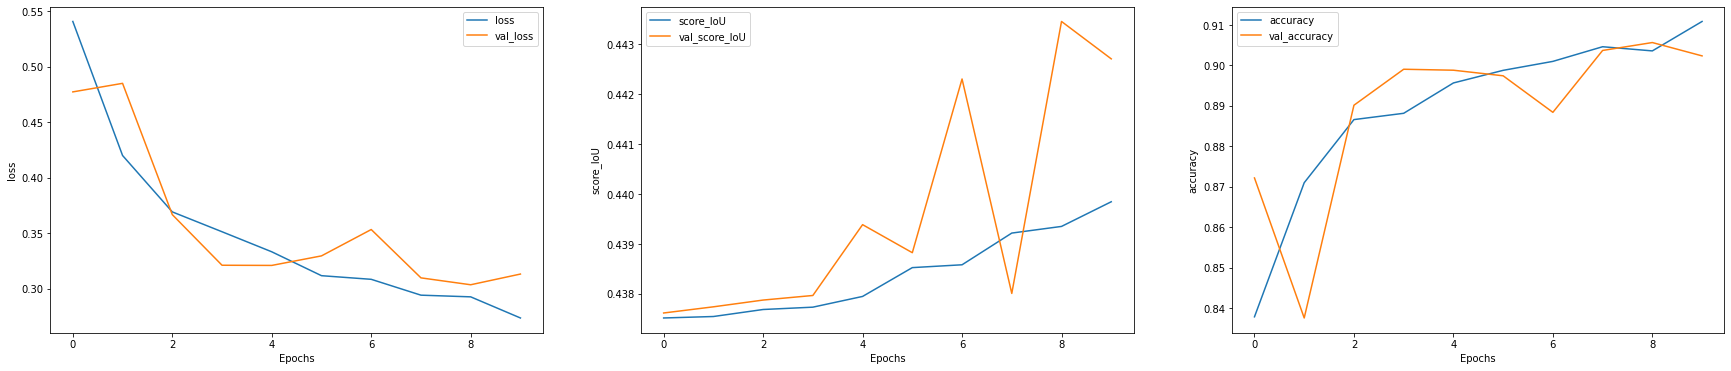

Training time : 5167.433057546616


In [ ]:
print(f'Training for augmented_{model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs,
            loss=None,
            do_augment=True,
            custom_augmentation=custom_augmentation,
            callbacks=callbacks,
            display_history=True)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/augmented_{model_name}.h5')

#### Evaluate the model

In [ ]:
start_eval = time()
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

500it [08:50,  1.06s/it]

Evaluation time : 530.9145722389221


#### Plot the images and mask

[468 418]


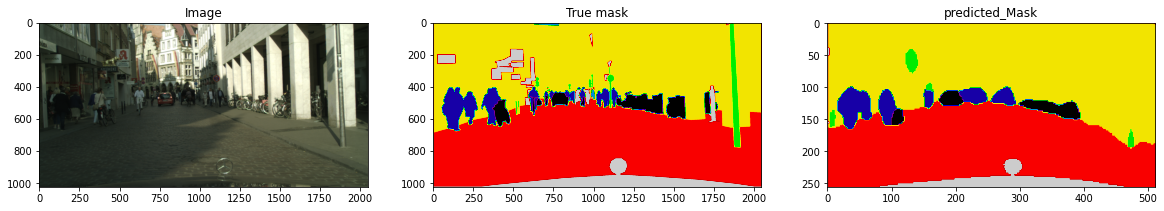

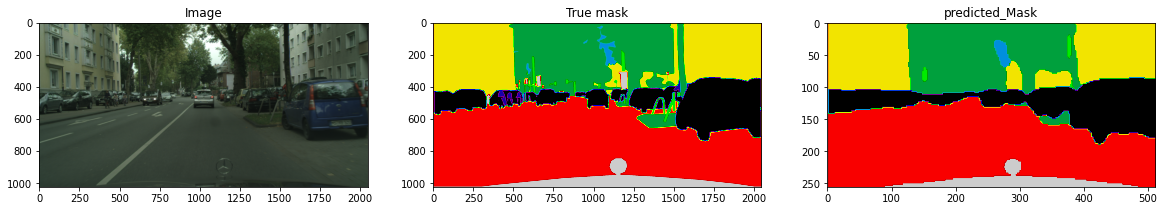

In [ ]:
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=True, n=2)

In [ ]:
# Append model's result to dataframe
def model_result_to_dataframe(model_name, epochs, training_time, eval_time, 
                              df_result, model_result, do_augment=False):

    if do_augment==True:
        model_name = (f'augmented_{model_name}')

    df_result =df_result.append(
        {'model':model_name,
         'epoch': epochs,
         'training_time':training_time,
         'eval_time':eval_time,
         'freq_weighted_IoU':model_result["frequency_weighted_IU"],
         'mean_IoU':model_result["mean_IU"],
         'void_IoU':model_result["class_wise_IU"][0],
         'flat_IoU':model_result["class_wise_IU"][1],
         'construction_IoU':model_result["class_wise_IU"][2],
         'object_IoU':model_result["class_wise_IU"][3],
         'nature_IoU':model_result["class_wise_IU"][4],
         'sky_IoU':model_result["class_wise_IU"][5],
         'human_IoU':model_result["class_wise_IU"][6],
         'vehicule_IoU':model_result["class_wise_IU"][7]},
         ignore_index=True)
    
    return df_result

In [ ]:
df_result = model_result_to_dataframe(model_name, epochs, training_time,
                                      eval_time, df_result, model_result,
                                      do_augment=True)

# Display result
df_result

,model,epoch,training_time,eval_time,mean_IoU,void_IoU,flat_IoU,construction_IoU,object_IoU,nature_IoU,sky_IoU,human_IoU,vehicule_IoU,freq_weighted_IoU
0,augmented_mobilenet_segnet,10,5167.433058,530.914572,0.682193,0.647402,0.909572,0.782567,0.265801,0.817544,0.785802,0.469787,0.77907,0.805658


### VGG Unet with augmentation

In [ ]:
model_name= 'vgg_unet'

# Call the model
model = vgg_unet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

58900480/58889256 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

Training for augmented_vgg_unet
Verifying training dataset


100%|██████████| 2400/2400 [03:38<00:00, 10.99it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 575/575 [00:52<00:00, 11.05it/s]


Dataset verified! 
Epoch 1/10
512/512 [==============================] - 245s 471ms/step - loss: 0.7264 - score_IoU: 0.4401 - accuracy: 0.7737 - val_loss: 0.6127 - val_score_IoU: 0.4375 - val_accuracy: 0.8129
Epoch 2/10
512/512 [==============================] - 236s 461ms/step - loss: 0.4927 - score_IoU: 0.4376 - accuracy: 0.8468 - val_loss: 0.8087 - val_score_IoU: 0.4375 - val_accuracy: 0.7361
Epoch 3/10
512/512 [==============================] - 235s 459ms/step - loss: 0.4430 - score_IoU: 0.4376 - accuracy: 0.8621 - val_loss: 0.4666 - val_score_IoU: 0.4375 - val_accuracy: 0.8515
Epoch 4/10
512/512 [==============================] - 234s 458ms/step - loss: 0.4038 - score_IoU: 0.4377 - accuracy: 0.8740 - val_loss: 0.6429 - val_score_IoU: 0.4375 - val_accuracy: 0.8620
Epoch 5/10
512/512 [==============================] - 231s 452ms/step - loss: 0.3964 - score_IoU: 0.4379 - accuracy: 0.8768 - val_loss: 0.3932 - val_score_IoU: 0.4382 - val_accuracy: 0.8792
Epoch 6/10
512/512 [===========

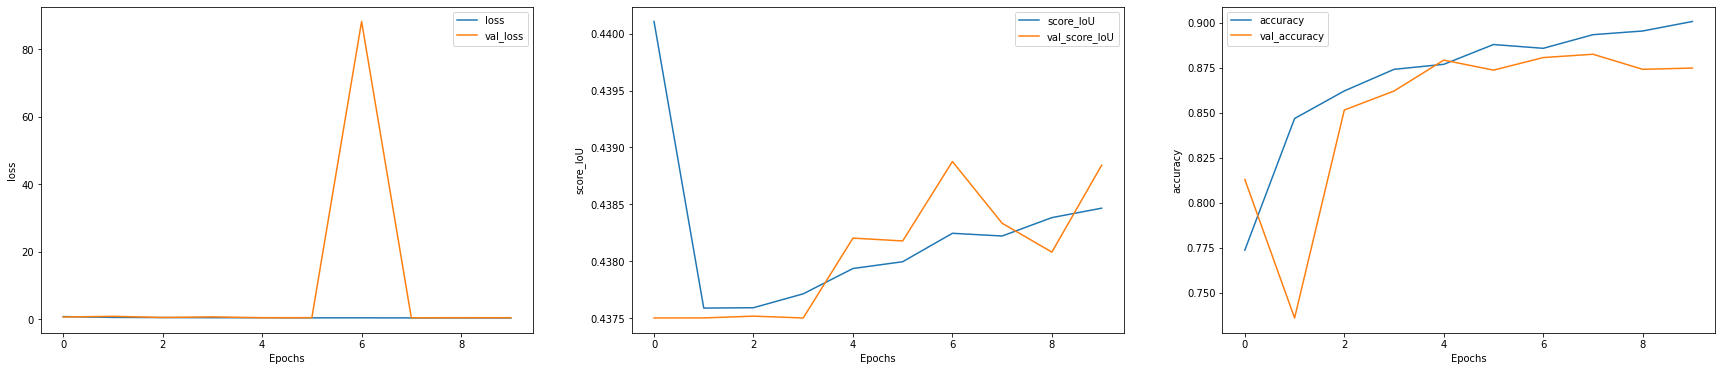

Training time : 2619.979030609131


In [ ]:
print(f'Training for augmented_{model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs,
            loss=None,
            do_augment=True,
            custom_augmentation=custom_augmentation,
            callbacks=callbacks,
            display_history=True)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/augmented_{model_name}.h5')

#### Evaluate the model

In [ ]:
start_eval = time()
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')


500it [01:36,  5.20it/s]

Evaluation time : 96.47720980644226


[458 179]


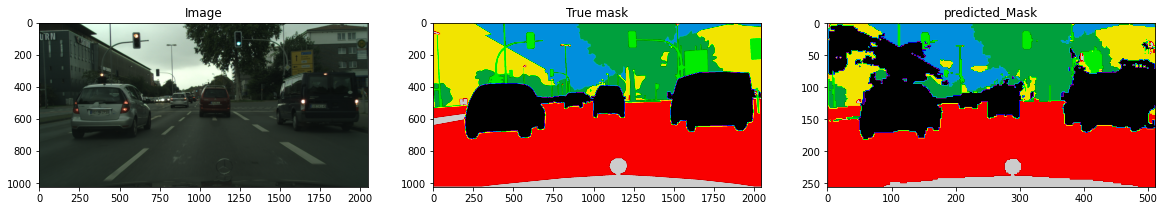

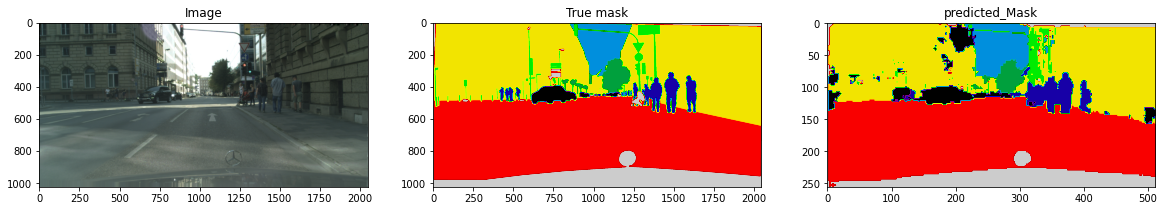

In [ ]:
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=True, n=2)

#### Comparison of the models vgg_unet and mobilenet_segnet with respect to augmenentation.

In [ ]:
df_result = model_result_to_dataframe(model_name, epochs, training_time,
                                      eval_time, df_result, model_result,
                                      do_augment=True)

# Display result
df_result

,model,epoch,training_time,eval_time,mean_IoU,void_IoU,flat_IoU,construction_IoU,object_IoU,nature_IoU,sky_IoU,human_IoU,vehicule_IoU,freq_weighted_IoU
0,augmented_mobilenet_segnet,10,5167.433058,530.914572,0.682193,0.647402,0.909572,0.782567,0.265801,0.817544,0.785802,0.469787,0.779070,0.805658
1,augmented_vgg_unet,10,2619.979031,96.477210,0.636826,0.649946,0.915057,0.684681,0.302433,0.825917,0.797405,0.346659,0.572509,0.773965
